<a href="https://colab.research.google.com/github/OctavioGuaschi/IA901-2023S1/blob/main/projetos/Human_physical_position_detection/notebooks/Detec%C3%A7%C3%A3o_de_posi%C3%A7%C3%A3o_f%C3%ADsica_humana_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
#@title Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#@title Python Imports
# Imports

# import the needed libs

from __future__ import print_function, division

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os
import copy
import random

plt.ion()   # interactive mode



# Neptune config

In [3]:
! pip install neptune-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


A partir das funções a seguir, foi possível selecionar os modelos de rede de melhor performance.

In [4]:
#@title Neptune Pickle Functions
import neptune.new as neptune
from neptune.types import File
import pickle

def neptune_start(name='Default'):
    run = neptune.init_run (project= 'octavioguaschi/IA901-218390',
                       name=name,
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")
    return run

def neptune_start_ID(with_id='Default'):
    run = neptune.init_run (project= 'octavioguaschi/IA901-218390',
                       with_id=with_id,
                       api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYTM4ZmY5My1iMzE5LTQ0MzQtOTA5MS02MzUzZTkxYTI0OGIifQ==")
    return run

def neptune_download_pickle():
    run["model/pickled_model"].download(destination="./model.pkl")
    file = open("/content/model.pkl",'rb')
    model = pickle.load(file)
    return model

/usr/local/lib/python3.10/dist-packages/neptune/internal/backends/hosted_client.py:50: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
<ipython-input-4-b123a986197f>:1: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  import neptune.new as neptune


Os modelos selecionados são os equivalentes ao modelo treinado do EfficientNet-B2 e à versão com fine tunning.

In [5]:
#@title Model Loader
run = neptune_start_ID("IA90-148")
print(run["sys/id"].fetch())
model = neptune_download_pickle()

<ipython-input-4-b123a986197f>:12: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run (project= 'octavioguaschi/IA901-218390',


https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-148
IA90-148


# Dataset Loader


In [6]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target, path

In [7]:
#@title Transforms and Dataloaders

# mean and standard deviation for normalization
def normilize_attributes(dataset):
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=1,
        num_workers=1,
        shuffle=False
    )

    mean = torch.zeros(3)
    std = torch.zeros(3)
    num_samples = len(dataset)

    for inputs, _ in loader:
        mean += torch.mean(inputs, dim=(0, 2, 3))
        std += torch.std(inputs, dim=(0, 2, 3))

    mean /= num_samples
    std /= num_samples

    return mean.tolist(), std.tolist()

dataset_for_normalize = datasets.ImageFolder('gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/train', transform=None)

# Data augmentation and normalization for training
normalize_transform = transforms.Compose([
        transforms.Resize((170,170)),
        transforms.ColorJitter(brightness=0.2, contrast=0., saturation=0., hue=0.),
        transforms.RandomPerspective(distortion_scale=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomEqualize(p=0.5),
        transforms.RandomInvert(p=0.5),
        transforms.RandomRotation(20),
        transforms.RandomGrayscale(),
        transforms.ToTensor(),
])

dataset_for_normalize.transform = normalize_transform

mean, std = normilize_attributes(dataset_for_normalize)

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        normalize_transform,
        transforms.Normalize(mean=mean, std=std)
    ]),
    'val': transforms.Compose([
        normalize_transform,
        transforms.Normalize(mean=mean, std=std)
    ])
}

# Datasets for training
image_datasets = {x: ImageFolderWithPath(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

# Dataloaders for training
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2) for x in ['train', 'val']}

# Train 237 (70%), Val 52 (15%), Test 51 (15%)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Seed lock for reprodutibility
seed = 1195

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
print(dataset_sizes)

{'train': 237, 'val': 52, 'test': 51}


Batch of training data


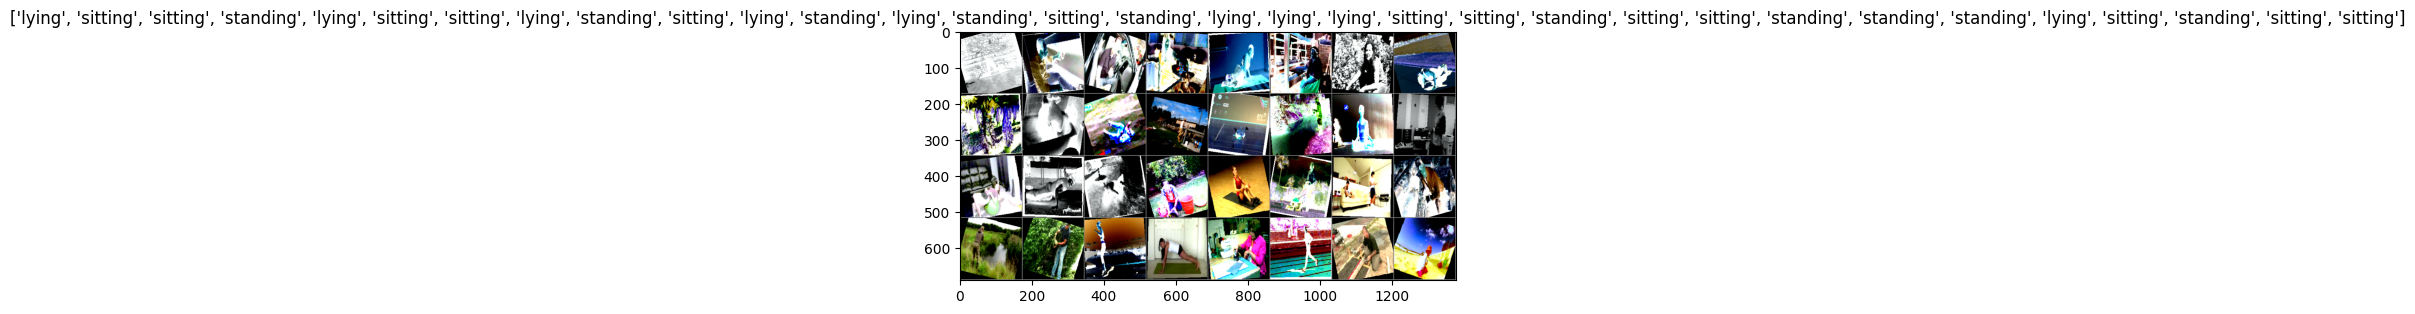

Batch of validation data


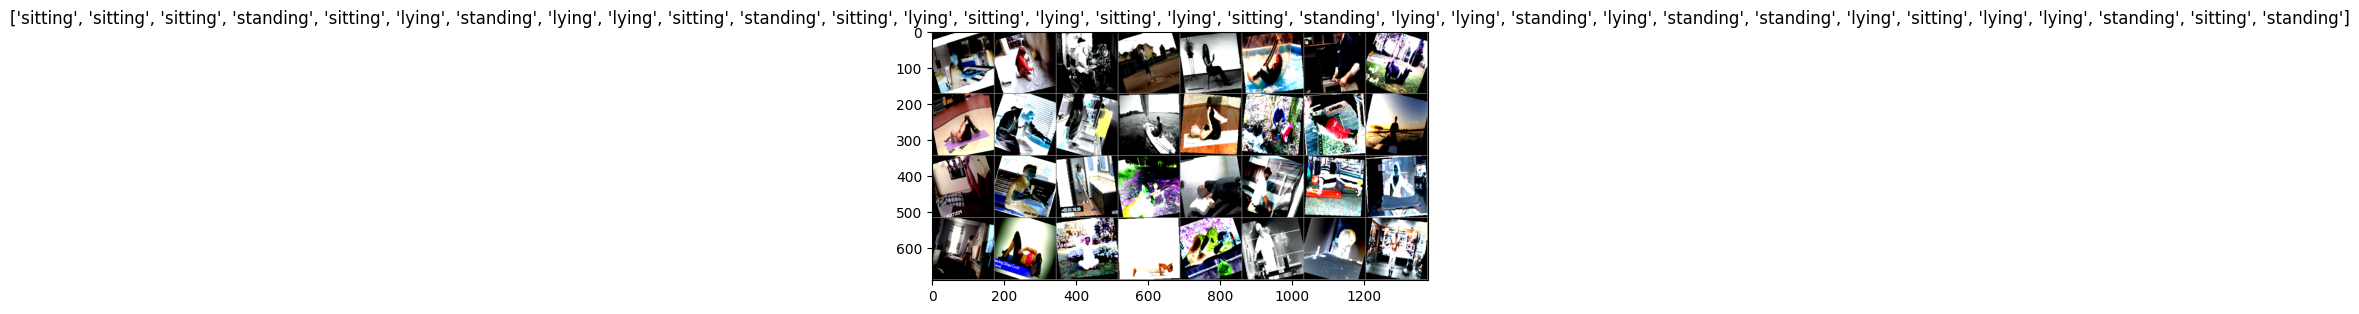

Batch of test data


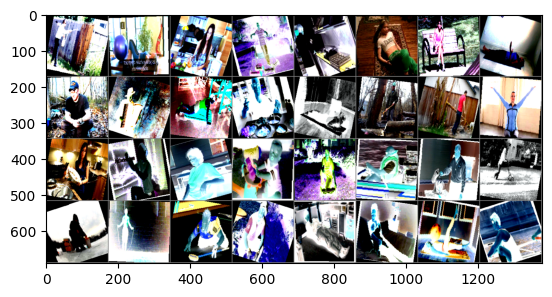

('gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/standing/003152219.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/lying/013008624.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/standing/000302087.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/standing/003282550.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/standing/000013469.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/lying/085573726.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/sitting/001541496.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/lying/026720728.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/sitting/000418744.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/sitting/005006453.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/lying/026517074.jpg', 'gdrive/MyDrive/Projeto/data/raw/DatasetFineTunning/test/sitting/000099186.jpg', 'gdrive/MyDrive/Projeto/data/ra

In [9]:
# Visualize batchs
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


print('Batch of training data')
inputs, classes, _ = next(iter(dataloaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)


print('Batch of validation data')
inputs, classes, _ = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

# Fine Tunning

Nesta etapa algumas camadas são congeladas com os valores do treino feito anteriormente, e a partir de um método de fine tunning, somente a camada classifier tem seu gradiente disponível para o treino das imagens inseridas.

In [12]:
#@title Layer Freeze
model = model.to(device)

# Define only classifier grad as True
classifier_params = set(model.classifier.parameters())

for param in model.parameters():
    if id(param) not in set(map(id, classifier_params)):
        param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.007, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

A função de treino é chamada novamente, porém com alguns cuidados quanto aos gradientes.

In [13]:
#@title Fine Tunning Train Function
def train_model_Neptune(model, criterion, optimizer, scheduler,neptune, num_epochs):
    since = time.time()
    run = neptune
    best_model_wts = copy.deepcopy(model.state_dict())
    PARAMS = {'model': model,
              'nb_epoch': num_epochs,
              'criterion': 'Cross',
              'optimizer': optimizer.defaults,
        }
    run['PARAMS'] = PARAMS

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()  # Modo de treinamento
        train_loss = 0.0
        train_correct = 0

        for images, labels, _ in dataloaders['train']:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_correct += torch.sum(preds == labels.data)

        epoch_train_loss = train_loss / dataset_sizes['train']
        train_accuracy = train_correct.double() / dataset_sizes['train']

        model.eval()  # Modo de avaliação
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels, _ in dataloaders['val']:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                val_correct += torch.sum(preds == labels.data)

            epoch_val_loss = val_loss / dataset_sizes['val']
            val_accuracy = val_correct.double() / dataset_sizes['val']

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print('-' * 10)
        print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
        print()

        # Salvar o modelo se a precisão na validação for a melhor até agora
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            #torch.save(model.state_dict(), 'efficientnetb2_finetuned.pth')

        run['train/epoch_loss'].append(epoch_train_loss)
        run['train/epoch_acc'].append(train_accuracy)

        run['val/epoch_loss'].append(epoch_val_loss)
        run['val/epoch_acc'].append(val_accuracy)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_val_accuracy))

    run["acc"] = best_val_accuracy
    run["time_elapsed"] = time_elapsed
    # load best model weights
    model.load_state_dict(best_model_wts)
    run["model/pickled_model"].upload(File.as_pickle(model))
    return model


A seguir o treinamento é realizado.

In [14]:
#@title Run training
run = neptune_start('model_finetunning')
model = train_model_Neptune(model, criterion, optimizer,exp_lr_scheduler, run, 23)

https://app.neptune.ai/octavioguaschi/IA901-218390/e/IA90-188


<ipython-input-13-d3c134b298b5>:10: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'torchvision.models.efficientnet.EfficientNet'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['PARAMS'] = PARAMS
<ipython-input-13-d3c134b298b5>:10: NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs.neptune.ai/help/value_of_unsupported_type
  run['PARAMS'] = PARAMS


Epoch [1/23]
----------
Train Loss: 284.2609, Accuracy: 0.4008
Val Loss: 55.3534, Accuracy: 0.4038

Epoch [2/23]
----------
Train Loss: 249.1985, Accuracy: 0.5148
Val Loss: 49.5916, Accuracy: 0.4423

Epoch [3/23]
----------
Train Loss: 218.4008, Accuracy: 0.5316
Val Loss: 51.4536, Accuracy: 0.5000

Epoch [4/23]
----------
Train Loss: 191.5914, Accuracy: 0.6371
Val Loss: 42.5117, Accuracy: 0.6923

Epoch [5/23]
----------
Train Loss: 188.0658, Accuracy: 0.6456
Val Loss: 40.9759, Accuracy: 0.6538

Epoch [6/23]
----------
Train Loss: 160.2433, Accuracy: 0.7257
Val Loss: 41.7578, Accuracy: 0.6346

Epoch [7/23]
----------
Train Loss: 153.9282, Accuracy: 0.7384
Val Loss: 37.3285, Accuracy: 0.6346

Epoch [8/23]
----------
Train Loss: 137.4307, Accuracy: 0.7806
Val Loss: 37.9865, Accuracy: 0.6346

Epoch [9/23]
----------
Train Loss: 164.4712, Accuracy: 0.7426
Val Loss: 42.6318, Accuracy: 0.6346

Epoch [10/23]
----------
Train Loss: 145.2680, Accuracy: 0.7595
Val Loss: 38.9565, Accuracy: 0.6538
